# Training With Non Default Parameters

SAS DLPy provides several API with default values set for the users. In addition to default values, DLPy enables users to easily override these default values. 

This example, first default values are used, then some of them are changed to show how easy making these changes with DLPy.

This example assumes that you have the SAS DLPy API installed, and have an active SAS CAS server.

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Configure CAS and Import SWAT

The following code configures your CAS session for deep learning tasks. 

First, import SWAT. SWAT is a Python interface to SAS CAS that enables you to load data into memory and apply CAS actions to the data.

<b>Note:</b> For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

In [2]:
# Configure CAS session for Analytics
# Import SWAT
import swat
conn = swat.CAS(cashost, casport)

# Exception handler for reading StringIO text data into memory
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
    
# SWAT data message handler
import swat.cas.datamsghandlers as dmh

# Python utility libraries
import pandas as pd
import numpy as np

### Getting the data, Embeddings, and a Text classification model

In [3]:
# Import DLPy
import dlpy
from dlpy import Sequential
from dlpy import *
from dlpy.model import TextParms
from dlpy.blocks import Bidirectional
from dlpy.applications import TextClassification

In [4]:
# load word embeddings: vector representations of words
# this example uses pre-trained word embeddings 
embeddings = pd.read_csv('/disk/linux/dlpy/word_embeddings.txt', skipinitialspace=True, index_col=False, delimiter='\t')
conn.upload_frame(embeddings, casout=dict(name='word_embeddings', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table WORD_EMBEDDINGS in caslib CASUSER(ethem-kinginthenorth).
NOTE: The table WORD_EMBEDDINGS has been created in caslib CASUSER(ethem-kinginthenorth) from binary data uploaded to Cloud Analytic Services.


CASTable('WORD_EMBEDDINGS', caslib='CASUSER(ethem-kinginthenorth)')

In [5]:
# create a toy dataset that has text input 
# as an example we will use sentiment analysis where the input is the review itself

sentiment_data = StringIO('''review,sentiment,stars
 "The line was too long and the food was just average. Not coming back again.","negative", 2
 "The desserts are to die for! You should definitely try the banana pudding!","positive", 5
 "My friends like this place so much but I don't understand what is so great. Just fine I guess.","neutral", 3 
 "I love the feeling in this place. From the decorations to the friendliness, it makes me feel happy!","positive", 5
 "I can't see any reason to go to this place. You pay top dollar for cold food","negative", 1
 "This is my favorite place to celebrate birthdays! They always have a cake! Yum!","positive", 4
 "Regular stuff. Salad, burger, hot dog. Nothing extraordinary.","neutral", 3
 "Wow! This was the best burger I had for years. You won't believe how juicy it was!","positive", 5
 "Their side salad is huge! Good value for the money.","positive", 4
 "I am not so crazy about the cold food in here","negative", 2
 "This place is really really expensive!!","negative", 1
 "You should definitely try the desserts","positive", 5
 "This place is just fine. Nothing more nothing less.","neutral", 3
 "Great food, wonderful atmosphere","positive", 5
 "I love this place! Such a nice restaurant to go to in weekends","positive", 5 
 "Worst restaurant ever!","negative", 2
 "Don\'t ever waste your time and money. Such a disaster!","negative", 1
 ''')
handler = dmh.CSV(sentiment_data, skipinitialspace=True)
conn.addtable(table='sentiment_data', replace=True, **handler.args.addtable)

[caslib]

 'CASUSER(ethem-kinginthenorth)'

[tableName]

 'SENTIMENT_DATA'

[casTable]

 CASTable('SENTIMENT_DATA', caslib='CASUSER(ethem-kinginthenorth)')

+ Elapsed: 0.00551s, user: 0.000231s, sys: 0.000426s, mem: 0.733mb

In [6]:
# create a sample test data as well
sentiment_test = StringIO('''review,sentiment,stars
 "I am not a fan of cold food especially if it is expensive...","negative", 2
 "Wow! I love this place. One of the best places to go for desserts! ","positive", 5
 "Regular stuff. Nothing extraordinary.","neutral", 3
 ''')
handler = dmh.CSV(sentiment_test, skipinitialspace=True)
conn.addtable(table='sentiment_test', replace=True, **handler.args.addtable)

[caslib]

 'CASUSER(ethem-kinginthenorth)'

[tableName]

 'SENTIMENT_TEST'

[casTable]

 CASTable('SENTIMENT_TEST', caslib='CASUSER(ethem-kinginthenorth)')

+ Elapsed: 0.00321s, user: 0.000521s, sys: 5.5e-05s, mem: 0.732mb

In [7]:
# create a simple RNN model for classifying reviews
easy_model = TextClassification(conn)

NOTE: Output layer added.
NOTE: Model compiled successfully.


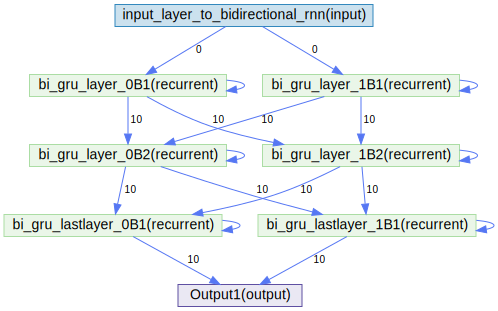

In [8]:
# visualize the model
easy_model.plot_network()

### Training with the default pararmeters

In [9]:
# train the sentiment analysis model
easy_model.fit(data='sentiment_data', 
               inputs='review', 
               texts='review', 
               target='sentiment', 
               nominals='sentiment',
               text_parms=TextParms(init_input_embeddings='word_embeddings'))

NOTE: Training from scratch.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 10443.
NOTE:  The approximate memory cost is 7.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       1.38 (s).
NOTE:  The total number of threads on each worker is 72.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 72.
NOTE:  Target variable: sentiment
NOTE:  Number of levels for the target variable:      3
NOTE:  Levels for the target variable:
NOTE:  Level      0: negative
NOTE:  Level      1: neutral 
NOTE:  Level      2: positive
NOTE:  Number of input variables:     1
NOTE:  Number of text input variables:      1
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Training)
NOTE:      0     1     0.01            0.875          0     0.00
NOTE:      1     1     0.01            2.137          1     0.00
NOTE:      2     1  

,Descr,Value
0,Model Name,text_classifier
1,Model Type,Recurrent Neural Network
2,Number of Layers,8
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,6
9,Number of Weight Parameters,10260


In [10]:
# changing learning rate, number of epochs to run, and log-levevl 
easy_model.fit(data='sentiment_data', 
               inputs='review', 
               texts='review',
               target='sentiment', 
               nominals='sentiment',
               text_parms=TextParms(init_input_embeddings='word_embeddings'),
               max_epochs=10, 
               lr=0.05, 
               log_level=2)

NOTE: Training based on existing weights.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 10443.
NOTE:  The approximate memory cost is 7.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       1.46 (s).
NOTE:  The total number of threads on each worker is 72.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 72.
NOTE:  Target variable: sentiment
NOTE:  Number of levels for the target variable:      3
NOTE:  Levels for the target variable:
NOTE:  Level      0: negative
NOTE:  Level      1: neutral 
NOTE:  Level      2: positive
NOTE:  Number of input variables:     1
NOTE:  Number of text input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0          0.05           1.208     0.6471     0.01
NOTE:  1          0.05           1.174     0.6471     0.01
NOTE:  2          0.05           1.0

,Descr,Value
0,Model Name,text_classifier
1,Model Type,Recurrent Neural Network
2,Number of Layers,8
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,6
9,Number of Weight Parameters,10260


In [11]:
# overriding default values for more advanced features
from dlpy.model import Optimizer
easy_model.fit(data='sentiment_data', 
               inputs='review', 
               texts='review',
               target='sentiment', 
               nominals='sentiment',
               text_parms=TextParms(init_input_embeddings='word_embeddings'),
               optimizer=Optimizer(mini_batch_size=10,
                                   max_epochs=3,
                                   reg_l1=0.001))

NOTE: Training based on existing weights.


,Descr,Value
0,Model Name,text_classifier
1,Model Type,Recurrent Neural Network
2,Number of Layers,8
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,6
9,Number of Weight Parameters,10260


In [12]:
# overriding more default parameters Optimizer and Algorithm
from dlpy.model import Optimizer, MomentumSolver
easy_model.fit(data='sentiment_data', 
               inputs='review', 
               texts='review',
               target='sentiment', 
               nominals='sentiment',
               text_parms=TextParms(init_input_embeddings='word_embeddings'),
               optimizer=Optimizer(mini_batch_size=10,
                                   max_epochs=3,
                                   reg_l1=0.001,
                                   algorithm=MomentumSolver(momentum=0.089)))

NOTE: Training based on existing weights.


,Descr,Value
0,Model Name,text_classifier
1,Model Type,Recurrent Neural Network
2,Number of Layers,8
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,6
9,Number of Weight Parameters,10260


In [13]:
# using another solver than Vanilla and Momentum
# overriding more default parameters Optimizer and Algorithm
from dlpy.model import Optimizer, AdamSolver
easy_model.fit(data='sentiment_data', 
               inputs='review', 
               texts='review',
               target='sentiment', 
               nominals='sentiment',
               text_parms=TextParms(init_input_embeddings='word_embeddings'),
               optimizer=Optimizer(mini_batch_size=10,
                                   max_epochs=3,
                                   reg_l1=0.001,
                                   algorithm=AdamSolver(beta1=0.901, beta2=0.988, learning_rate=0.03)))

NOTE: Training based on existing weights.


,Descr,Value
0,Model Name,text_classifier
1,Model Type,Recurrent Neural Network
2,Number of Layers,8
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,6
9,Number of Weight Parameters,10260
